In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [50]:
data = pd.read_csv('../data/cleaned_data_3.csv')
df = pd.DataFrame(data)

In [51]:
# one-hot encode wheel size, categorical variable
df = pd.get_dummies(df, columns=['Wheel Size'], prefix='Wheel')

In [52]:
df.columns

Index(['URL', 'Brand', 'Model', 'Year', 'Category', 'Motorized', 'Frame Size',
       'Reach', 'Stack', 'STR', 'Head Tube Angle', 'Seat Tube Angle Effective',
       'Head Tube Length', 'Seat Tube Length', 'Chainstay Length', 'Wheelbase',
       'Bottom Bracket Offset', 'Suspension Travel (rear)',
       'Suspension Travel (front)', 'Discipline', 'Wheel_26', 'Wheel_27.5',
       'Wheel_29', 'Wheel_Mullet'],
      dtype='object')

In [53]:
# create feature list using geometry columns
feature_cols = ['Reach', 'Stack', 'STR', 'Head Tube Angle', 'Seat Tube Angle Effective',
       'Head Tube Length', 'Seat Tube Length', 'Chainstay Length', 'Wheelbase',
       'Bottom Bracket Offset', 'Suspension Travel (rear)',
       'Suspension Travel (front)', 'Wheel_26', 'Wheel_27.5', 'Wheel_29',
       'Wheel_Mullet']

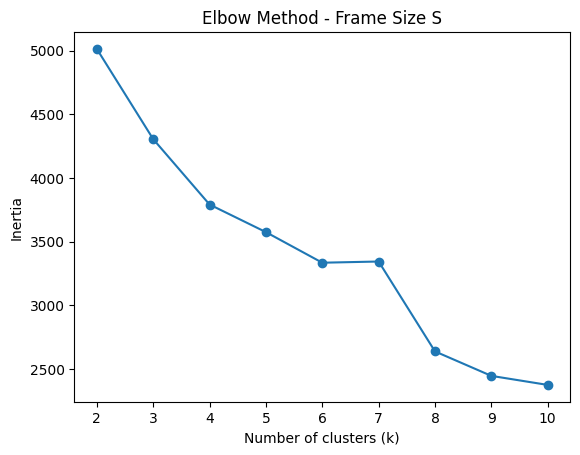

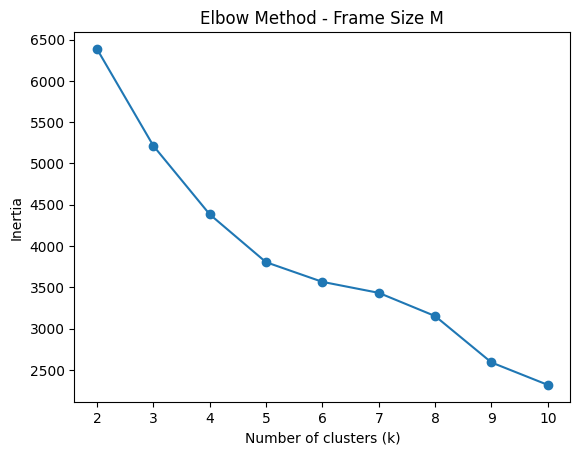

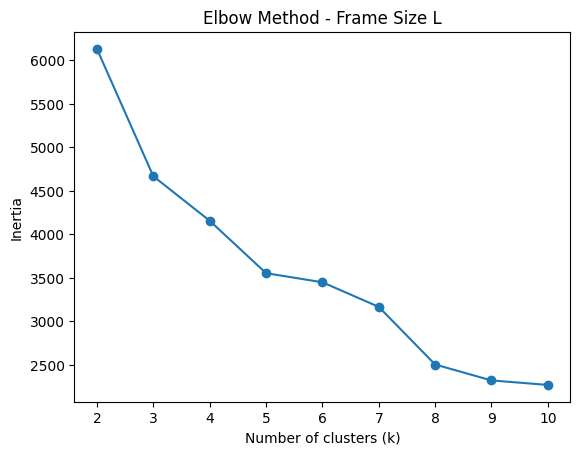

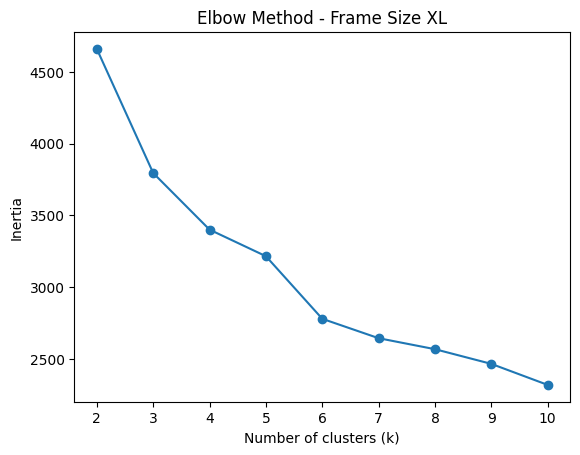

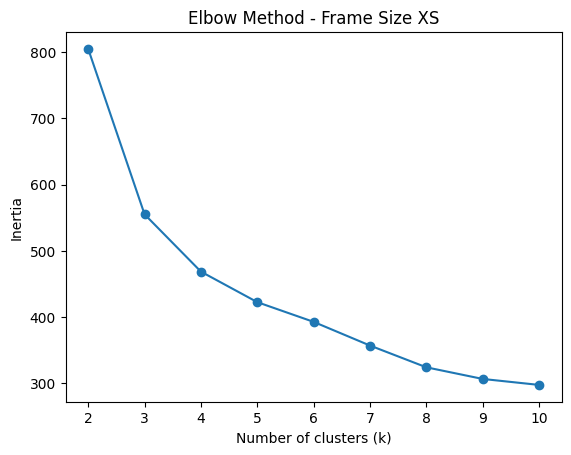

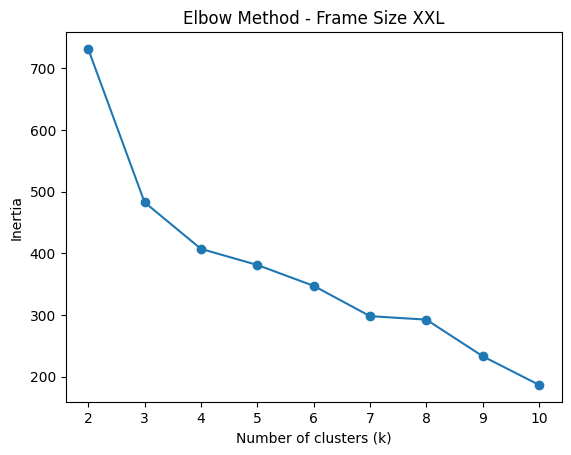

In [43]:
# since I want to cluster frames within their own size categories, I will run a loop for each size category
for size in df['Frame Size'].unique():

    # filter dataset based on size
    size_df = df[df['Frame Size'] == size]
    
    # get features
    X = size_df[feature_cols]
    
    # standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # calculate intertia to determine best k-value
    inertia = []
    k_values = range(2, 11)
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_scaled)
        inertia.append(kmeans.inertia_)
    
    # plot elbow curve
    plt.figure()
    plt.plot(k_values, inertia, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title(f'Elbow Method - Frame Size {size}')
    plt.show()

5 or 6 both seem like good options but 5 seems better since I don't want too many geometry characteristic clusters as this could get confusing.

In [ ]:
size_col = 'Frame Size'
disc_col = 'Discipline'
k = 3

df = df.copy()
df['Cluster'] = pd.NA

scalers = {}
models = {}

for disc in df[disc_col].unique():
    for size in df[size_col].unique():
        mask = (df[disc_col] == disc) & (df[size_col] == size)
        idx = df.index[mask]

        # skip tiny groups
        if len(idx) < k:
            print(f"Skipping {disc} / {size}: only {len(idx)} rows (< k={k})")
            continue

        X = df.loc[idx, feature_cols].copy()

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        km = KMeans(n_clusters=k, random_state=42, n_init='auto')  # use n_init=10 if your sklearn is older
        labels = km.fit_predict(X_scaled)

        df.loc[idx, 'Cluster'] = labels

        scalers[(disc, size)] = scaler
        models[(disc, size)]  = km


Skipping DH / XS: only 1 rows (< k=3)
Skipping DH / XXL: only 1 rows (< k=3)


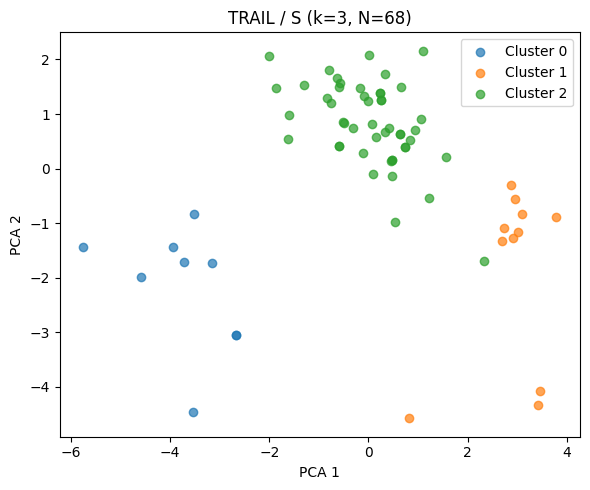

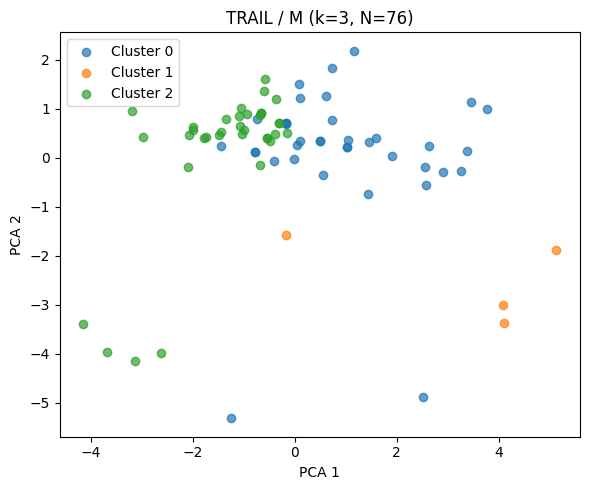

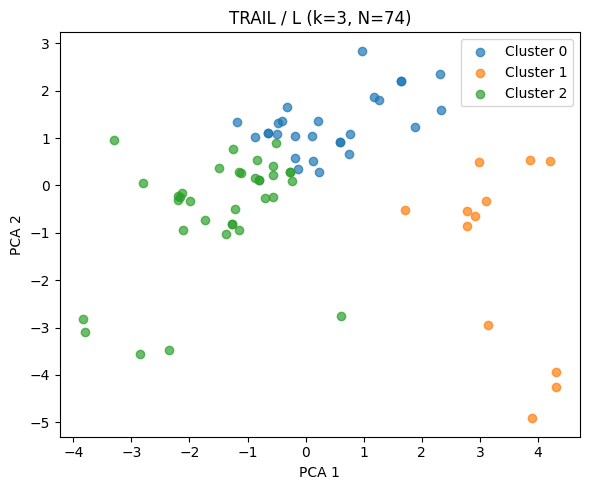

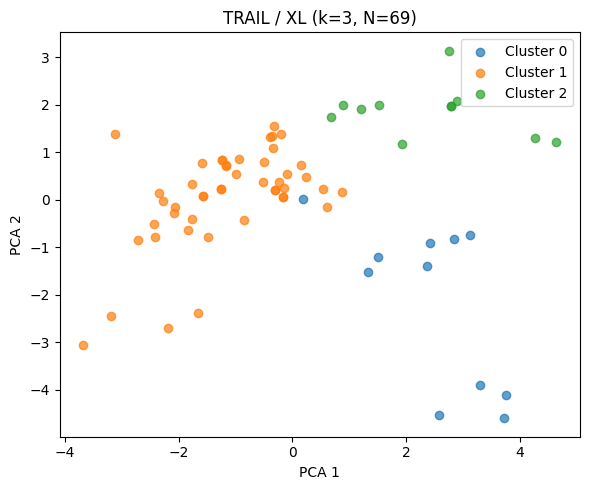

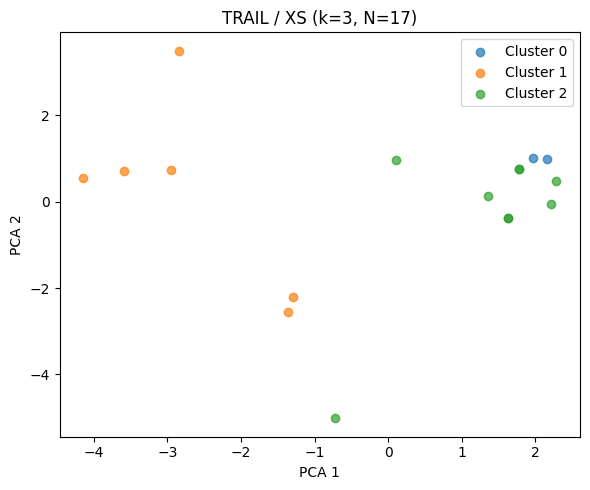

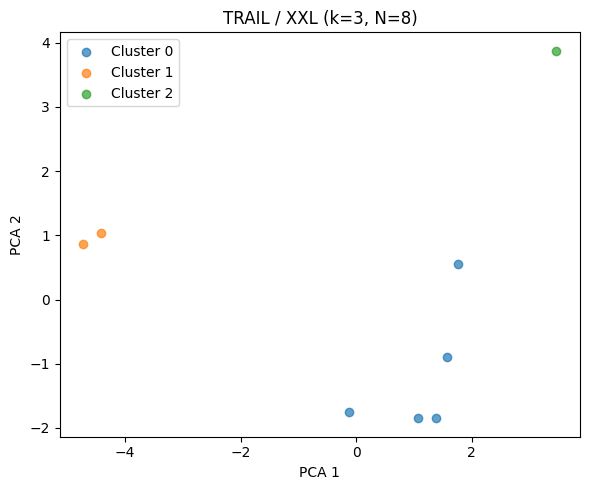

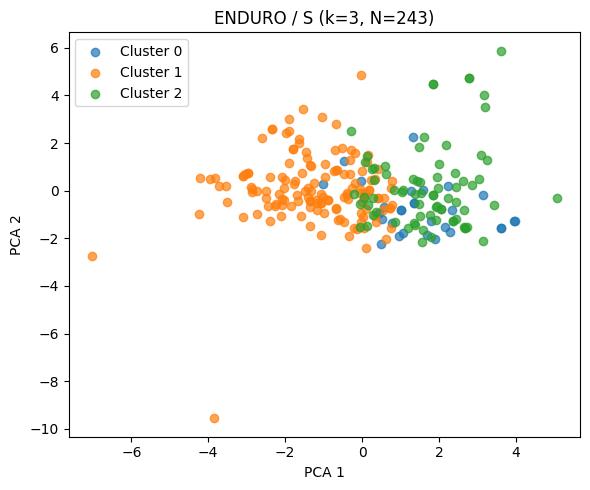

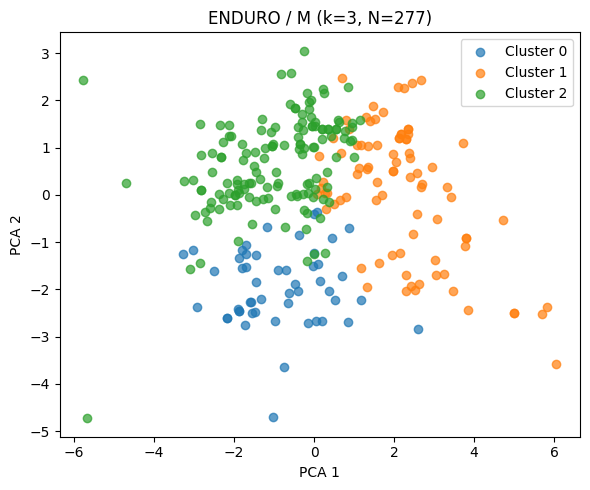

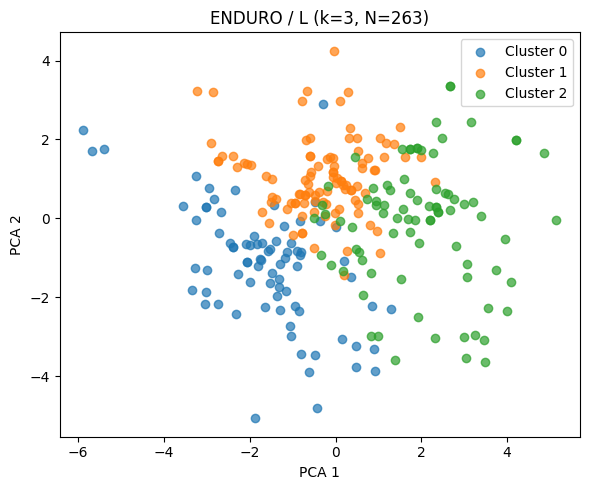

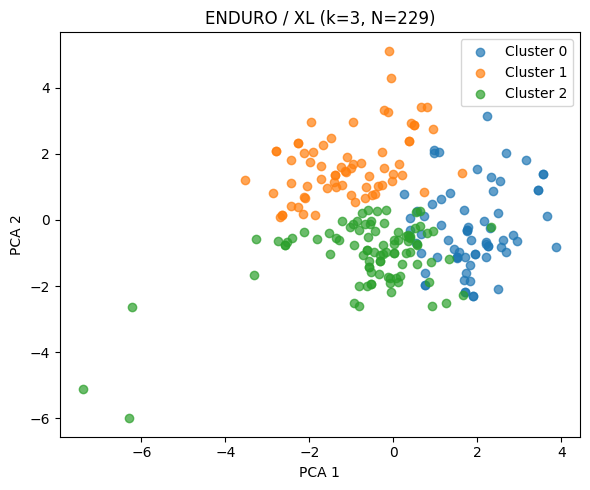

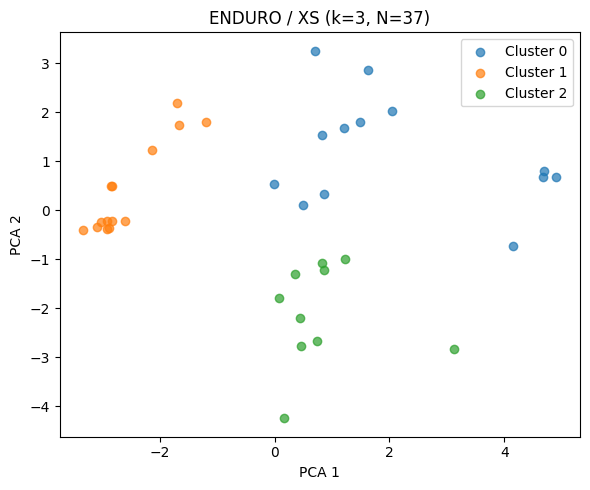

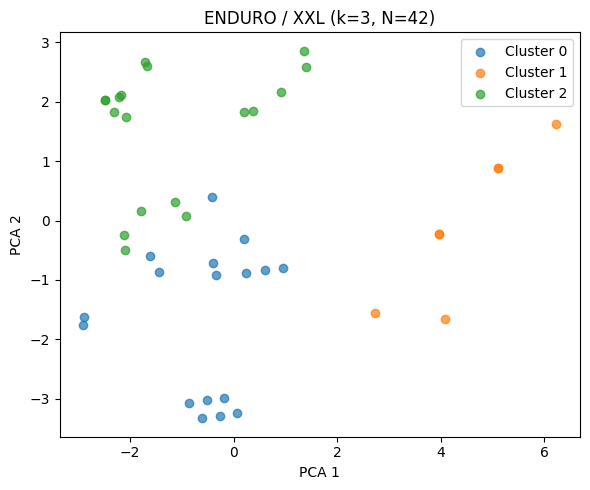

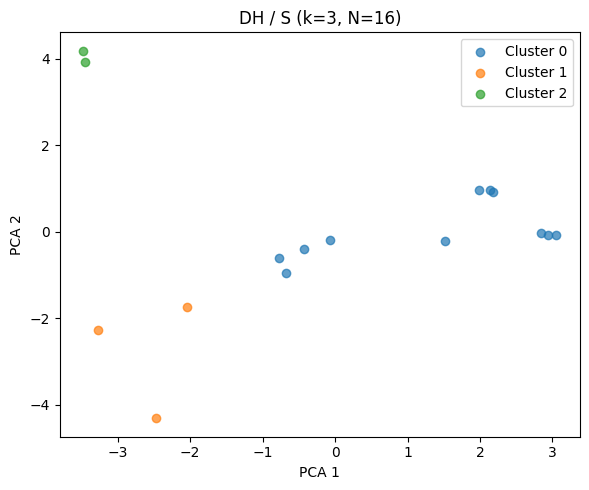

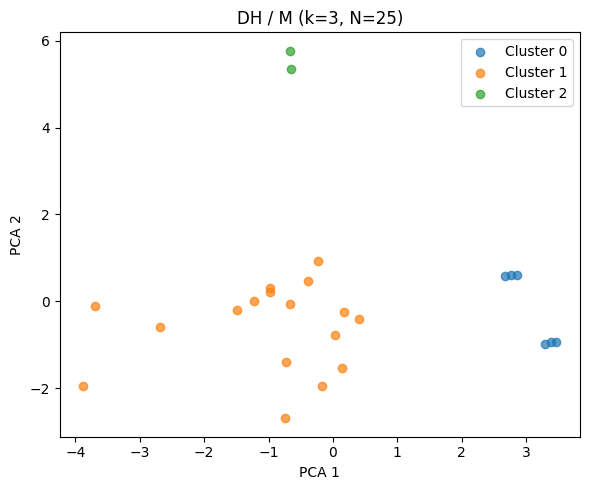

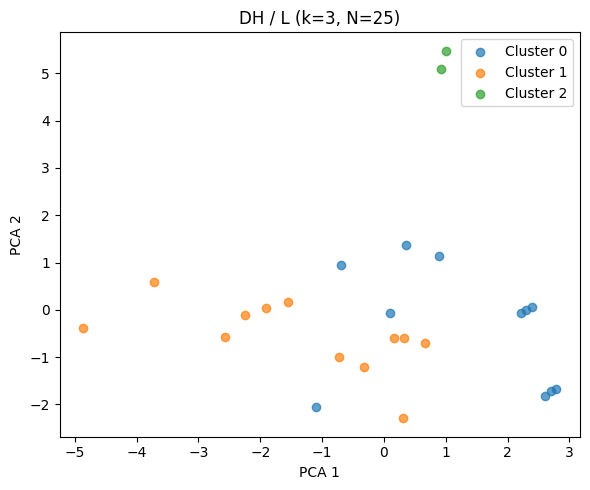

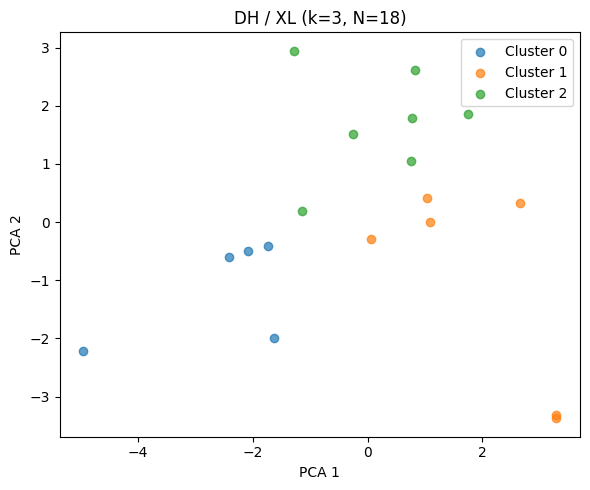

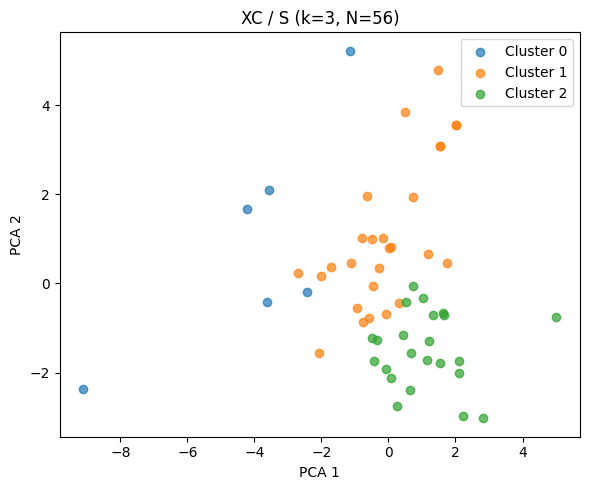

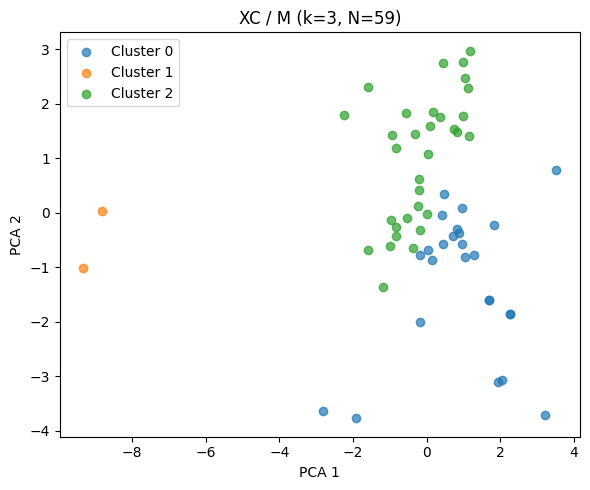

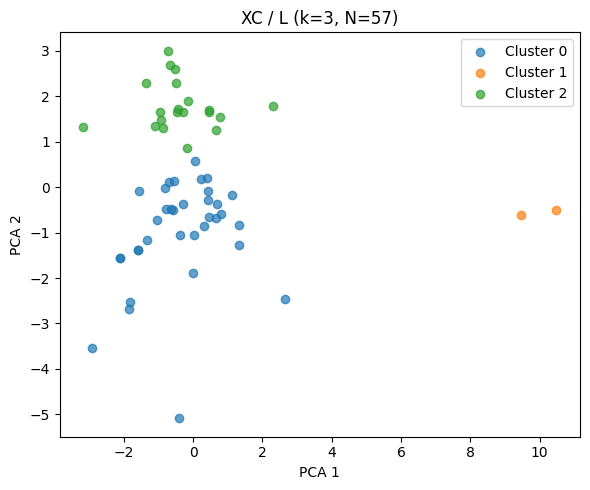

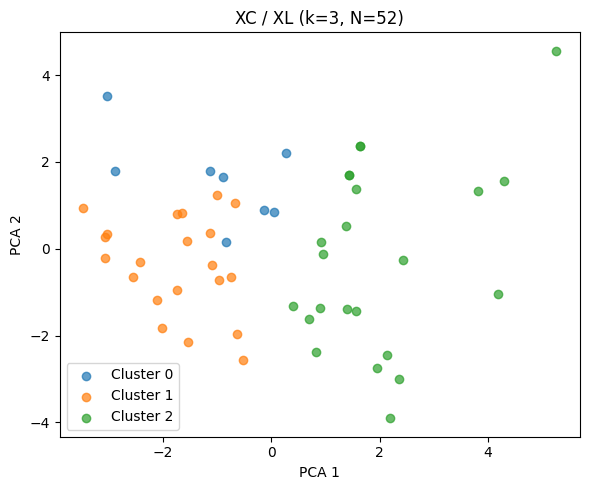

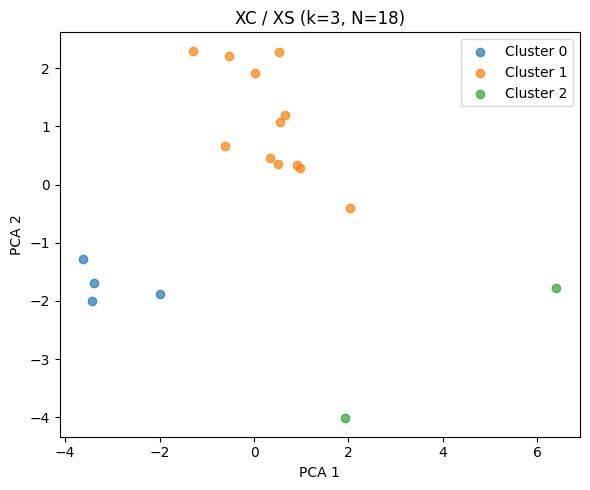

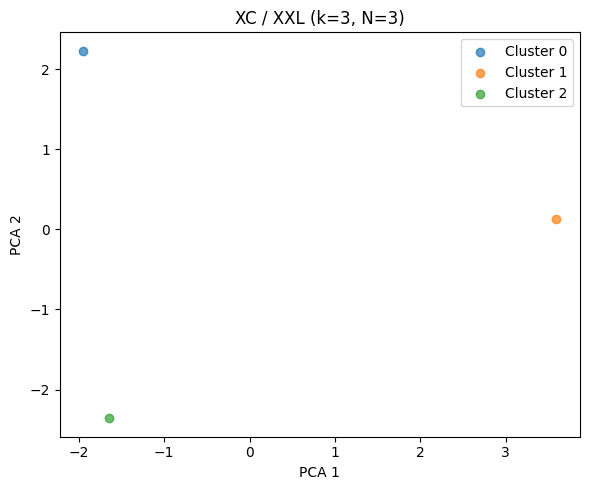

In [55]:
for (disc, size), scaler in scalers.items():
    mask = (df[disc_col] == disc) & (df[size_col] == size)
    idx = df.index[mask]
    X = df.loc[idx, feature_cols]
    X_scaled = scaler.transform(X)
    coords = PCA(n_components=2, random_state=42).fit_transform(X_scaled)
    labels = df.loc[idx, 'Cluster'].astype(int).to_numpy()

    plt.figure(figsize=(6,5))
    for c in np.unique(labels):
        sel = labels == c
        plt.scatter(coords[sel,0], coords[sel,1], label=f'Cluster {c}', alpha=0.7)
    plt.title(f'{disc.upper()} / {size} (k={k}, N={len(idx)})')
    plt.xlabel('PCA 1'); plt.ylabel('PCA 2'); plt.legend(); plt.tight_layout()
    plt.show()


In [ ]:
# to be able to see whole df
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)        # Don't wrap lines
pd.set_option('display.max_colwidth', None) # Show full column contents

df.groupby(['Discipline', 'Frame Size', 'Cluster'])[feature_cols].mean()

Reach       Stack       STR  \
Discipline Frame Size Cluster                                     
DH         L          0        481.181818  632.790909  1.316046   
                      1        466.450000  632.700000  1.356700   
                      2        486.000000  647.500000  1.332340   
           M          0        470.000000  628.500000  1.337565   
                      1        442.429412  630.341176  1.425031   
                      2        458.000000  647.500000  1.413797   
           S          0        437.727273  629.090909  1.438915   
                      1        405.066667  622.833333  1.538108   
                      2        433.000000  647.500000  1.495429   
           XL         0        481.800000  629.060000  1.305846   
                      1        502.833333  641.600000  1.276120   
                      2        499.071429  639.671429  1.281805   
Enduro     L          0        475.984810  623.863671  1.311677   
                      1        484.090891  635.767822  1.313879   
                      2        480.083133  639.833373  1.333740   
           M          0        452.317647  622.317451  1.377074   
                      1        458.544706  631.403765  1.378491   
                      2        455.040922  621.873191  1.446680   
           S          0        415.541379  621.506897  1.496181   
                      1        433.482014  612.884892  1.414592   
                      2        438.017333  624.832267  1.427931   
           XL         0        504.717391  648.669565  1.286020   
                      1        501.791449  642.926667  1.282120   
                      2        510.273846  638.812967  1.252195   
           XS         0        415.461538  619.038462  1.491397   
                      1        403.142857  578.321429  1.434628   
                      2        424.400000  609.200000  1.436145   
           XXL        0        532.935294  651.147059  1.222907   
                      1        559.000000  666.714286  1.192978   
                      2        513.811111  657.788889  1.280821   
Trail      L          0        469.881481  628.281481  1.337797   
                      1        466.666667  641.041667  1.373789   
                      2        482.228571  630.285429  1.307391   
           M          0        444.751351  621.713514  1.398462   
                      1        449.500000  636.100000  1.416368   
                      2        456.714286  619.485429  1.356896   
           S          0        430.777778  586.447778  1.362540   
                      1        420.090909  620.636364  1.477428   
                      2        427.916667  612.692917  1.432544   
           XL         0        494.090909  646.963636  1.309654   
                      1        506.404255  638.963617  1.262159   
                      2        483.618182  654.245455  1.353133   
           XS         0        408.500000  598.500000  1.465120   
                      1        422.666667  603.666667  1.429824   
                      2        401.333333  574.733333  1.432667   
           XXL        0        535.200000  646.400000  1.207891   
                      1        514.000000  656.500000  1.277244   
                      2        540.000000  637.000000  1.179630   
XC         L          0        442.611429  630.134286  1.757318   
                      1        426.000000  558.000000  1.310295   
                      2        471.425000  608.210000  1.290472   
           M          0        432.416000  623.628000  1.444103   
                      1        415.000000  558.500000  1.347762   
                      2        429.993750  599.852813  1.720271   
           S          0        402.166667  587.766667  1.462335   
                      1        412.951852  612.988519  1.485123   
                      2        425.091304  591.917391  1.393386   
           XL         0        505.162500  642.337500  1.272187   
                

### Now to interpret the clusters
The idea behind k=3 clusters is to group bikes based on their geometry characteristics that fit into 3 riding style categories:

    A) Long and slack, more stable over rough terrain and at high speeds

    B) A balanced option between the both of those that offers a compromise between speed and agility

    C) Short and steep for playful, agile riding styles

Using my knowledge of bike geometry and riding styles, I can interpret the clusters as follows:
(In the format of [A, B, C] as defined above)

DH:

XS = not enough data;
S = [0, 2, 1];
M = [0, 2, 1];
L = [2, 1, 0];
XL = [1, 2, 0];
XXL = not enough data

Enduro:

XS = [0, 1, 2];
S = [2, 1, 0];
M = [1, 2, 0];
L = [2, 1, 0];
XL = [0, 2, 1];
XXL = [1, 0, 2]

Trail:

XS = [1, 0, 2];
S = [0 , 1, 2];
M = [2, 1, 0];
L = [2, 0, 1];
XL = [1, 0, 2];
XXL = [2, 0, 1]

XC:

XS = [2, 1, 0];
S = [2, 1, 0];
M = [0, 2, 1];
L = [2, 0, 1];
XL = [0, 1, 2];
XXL = [2, 0, 1]


### Now to apply the clusters to the data

In [66]:
df = df.dropna(subset=['Cluster'])

In [67]:
cluster_styles = {
    # --- XC ---
    ('XC', 'XS', 2): 'Aggressive',
    ('XC', 'XS', 1): 'Balanced',
    ('XC', 'XS', 0): 'Playful',

    ('XC', 'S', 2): 'Aggressive',
    ('XC', 'S', 1): 'Balanced',
    ('XC', 'S', 0): 'Playful',

    ('XC', 'M', 0): 'Aggressive',
    ('XC', 'M', 2): 'Balanced',
    ('XC', 'M', 1): 'Playful',

    ('XC', 'L', 2): 'Aggressive',
    ('XC', 'L', 0): 'Balanced',
    ('XC', 'L', 1): 'Playful',

    ('XC', 'XL', 0): 'Aggressive',
    ('XC', 'XL', 1): 'Balanced',
    ('XC', 'XL', 2): 'Playful',

    ('XC', 'XXL', 2): 'Aggressive',
    ('XC', 'XXL', 0): 'Balanced',
    ('XC', 'XXL', 1): 'Playful',

    # --- Trail ---
    ('Trail', 'XS', 1): 'Aggressive',
    ('Trail', 'XS', 0): 'Balanced',
    ('Trail', 'XS', 2): 'Playful',

    ('Trail', 'S', 0): 'Aggressive',
    ('Trail', 'S', 1): 'Balanced',
    ('Trail', 'S', 2): 'Playful',

    ('Trail', 'M', 2): 'Aggressive',
    ('Trail', 'M', 1): 'Balanced',
    ('Trail', 'M', 0): 'Playful',

    ('Trail', 'L', 2): 'Aggressive',
    ('Trail', 'L', 0): 'Balanced',
    ('Trail', 'L', 1): 'Playful',

    ('Trail', 'XL', 1): 'Aggressive',
    ('Trail', 'XL', 0): 'Balanced',
    ('Trail', 'XL', 2): 'Playful',

    ('Trail', 'XXL', 2): 'Aggressive',
    ('Trail', 'XXL', 0): 'Balanced',
    ('Trail', 'XXL', 1): 'Playful',

    # --- Enduro ---
    ('Enduro', 'XS', 0): 'Aggressive',
    ('Enduro', 'XS', 1): 'Balanced',
    ('Enduro', 'XS', 2): 'Playful',

    ('Enduro', 'S', 2): 'Aggressive',
    ('Enduro', 'S', 1): 'Balanced',
    ('Enduro', 'S', 0): 'Playful',

    ('Enduro', 'M', 1): 'Aggressive',
    ('Enduro', 'M', 2): 'Balanced',
    ('Enduro', 'M', 0): 'Playful',

    ('Enduro', 'L', 2): 'Aggressive',
    ('Enduro', 'L', 1): 'Balanced',
    ('Enduro', 'L', 0): 'Playful',

    ('Enduro', 'XL', 0): 'Aggressive',
    ('Enduro', 'XL', 2): 'Balanced',
    ('Enduro', 'XL', 1): 'Playful',

    ('Enduro', 'XXL', 1): 'Aggressive',
    ('Enduro', 'XXL', 0): 'Balanced',
    ('Enduro', 'XXL', 2): 'Playful',

    # --- DH ---
    ('DH', 'XS', 0): 'Not enough data',
    ('DH', 'XS', 1): 'Not enough data',
    ('DH', 'XS', 2): 'Not enough data',

    ('DH', 'S', 0): 'Aggressive',
    ('DH', 'S', 2): 'Balanced',
    ('DH', 'S', 1): 'Playful',

    ('DH', 'M', 0): 'Aggressive',
    ('DH', 'M', 2): 'Balanced',
    ('DH', 'M', 1): 'Playful',

    ('DH', 'L', 2): 'Aggressive',
    ('DH', 'L', 1): 'Balanced',
    ('DH', 'L', 0): 'Playful',

    ('DH', 'XL', 1): 'Aggressive',
    ('DH', 'XL', 2): 'Balanced',
    ('DH', 'XL', 0): 'Playful',

    ('DH', 'XXL', 0): 'Not enough data',
    ('DH', 'XXL', 1): 'Not enough data',
    ('DH', 'XXL', 2): 'Not enough data',
}


In [69]:
df['Riding Style'] = df.apply(
    lambda row: cluster_styles[(row['Discipline'], row['Frame Size'], row['Cluster'])],
    axis=1
)
df.head()

/tmp/ipykernel_70423/4104218918.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Riding Style'] = df.apply(


,URL,Brand,Model,Year,Category,Motorized,Frame Size,Reach,Stack,STR,Head Tube Angle,Seat Tube Angle Effective,Head Tube Length,Seat Tube Length,Chainstay Length,Wheelbase,Bottom Bracket Offset,Suspension Travel (rear),Suspension Travel (front),Discipline,Wheel_26,Wheel_27.5,Wheel_29,Wheel_Mullet,Cluster,Riding Style
0,https://geometrics.mtb-news.de/bike/alchemy-argos-2022.480,Alchemy,Argos,2022,Mountain,0,S,424.0,624.0,1.471698,65.0,75.5,90.0,400.0,435.0,1167.0,60.0,0.0,140.0,Trail,False,False,True,False,1,Balanced
1,https://geometrics.mtb-news.de/bike/alchemy-argos-2022.480,Alchemy,Argos,2022,Mountain,0,M,454.0,624.0,1.374449,65.0,75.5,90.0,425.0,435.0,1197.0,60.0,0.0,140.0,Trail,False,False,True,False,0,Playful
2,https://geometrics.mtb-news.de/bike/alchemy-argos-2022.480,Alchemy,Argos,2022,Mountain,0,L,478.0,633.0,1.324268,65.0,75.5,100.0,450.0,435.0,1225.0,60.0,0.0,140.0,Trail,False,False,True,False,1,Playful
3,https://geometrics.mtb-news.de/bike/alchemy-argos-2022.480,Alchemy,Argos,2022,Mountain,0,XL,501.0,643.0,1.283433,65.0,75.5,110.0,490.0,435.0,1252.0,60.0,0.0,140.0,Trail,False,False,True,False,0,Balanced
4,https://geometrics.mtb-news.de/bike/alutech-efanes-29275-comp-2022.1010,Alutech,eFanes 29/275 Comp,2022,Mountain,1,S,430.0,613.0,1.425581,63.5,76.5,110.0,380.0,441.0,1144.0,9.0,170.0,170.0,Enduro,False,False,False,True,2,Aggressive
